In [1]:
import numpy as np
import pandas as pd
import time
import random
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.models import load_model
from scipy import ndimage, misc
import gym
import matplotlib.pyplot as plt

/home/sam.williams/python3.6/lib64/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
def process_obs(obs):
    obs = obs.max(axis=-1,keepdims=1)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    obs = obs.reshape((210,160))
    obs = misc.imresize(obs, (110,84))
    obs = obs[18:102,:,]
    obs = np.expand_dims(obs,2)
    #obs = np.expand_dims(obs,0)
    return obs

In [4]:
env = gym.make("Breakout-v0")
init = env.reset()

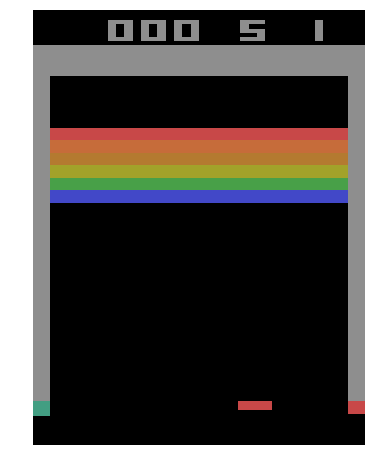

In [5]:
plot_state(init)

In [6]:
I = process_obs(init)

/home/sam.williams/python3.6/lib64/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [7]:
I.shape

(84, 84, 1)

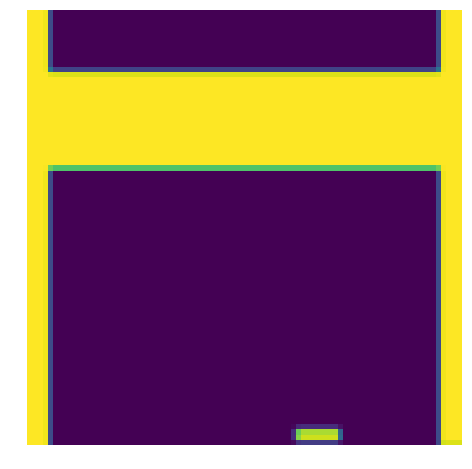

In [8]:
plot_state(I.reshape(84,84))

In [9]:
env.action_space

Discrete(4)

In [10]:
env.observation_space.shape

(210, 160, 3)

In [11]:
inp = Input(shape=(84,84,1))
x = Conv2D(8, (5,5), padding="same")(inp)
x = Conv2D(16, (5,5), padding="same")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
callbacks_list = [keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.9, patience=2)]
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=["mae"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 84, 84, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 8)         208       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 84, 16)        3216      
_________________________________________________________________
flatten_1 (Flatten)          (None, 112896)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               57803264  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 57,808,740
Trainable params: 57,808,740
Non-trainable params: 0
________________________________________________________________

In [12]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)


episodes = 1000
epsilon = 0.5
gamma = 0.9
done = False

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...\n".format(i, episodes))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    game = True
    while game:
        
        rand = np.random.uniform(0,1)
        if  rand < epsilon:
            action = env.action_space.sample()
        else:
            observation = np.expand_dims(observation,0)
            action = np.argmax(model.predict(observation))
          
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(reward)
        sum += reward
        
        #time.sleep(0.001)
        #env.render()
        
        if done:
        
            Q = []
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0, 0, 0]])
                    val[0,history["action"][-1-j]] = k + gamma*Q[-1][0].sum()
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])


            history["Q"] = Q 
            
            if sum < 4:
                observation = env.reset()
                observation = process_obs(observation)
                game = False
            else:
                print("Training the model...")
                
                history["input"] = np.array(history["input"])
                print(history["input"].shape)
                model.fit(history["input"], history["Q"], epochs = 4, batch_size=100, callbacks=callbacks_list)
                print("Total game score was: {}\n".format(sum))
            
                observation = env.reset()
                observation = process_obs(observation)
                #epsilon -= 0.01
                game = False
                             
        else:
            pass
            
         

/home/sam.williams/python3.6/lib64/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


Welcome to AI Breakout!
Starting Game 1 of 1000...

Welcome to AI Breakout!
Starting Game 2 of 1000...

Welcome to AI Breakout!
Starting Game 3 of 1000...

Welcome to AI Breakout!
Starting Game 4 of 1000...

Welcome to AI Breakout!
Starting Game 5 of 1000...

Welcome to AI Breakout!
Starting Game 6 of 1000...

Welcome to AI Breakout!
Starting Game 7 of 1000...

Welcome to AI Breakout!
Starting Game 8 of 1000...

Training the model...
(538, 84, 84, 1)
Epoch 1/4
538/538 [==============================] - 11s 21ms/step - loss: 263516740.5035 - mean_absolute_error: 7554.2905
Epoch 2/4
538/538 [==============================] - 11s 20ms/step - loss: 176125.6457 - mean_absolute_error: 323.3879
Epoch 3/4
538/538 [==============================] - 11s 20ms/step - loss: 197411.3232 - mean_absolute_error: 378.7901
Epoch 4/4
538/538 [==============================] - 11s 20ms/step - loss: 412219.6480 - mean_absolute_error: 479.0459
Total game score was: 6.0

Welcome to AI Breakout!
Starting Game 

In [15]:
#model.predict(observation)

In [16]:
observation.shape

(84, 84, 1)

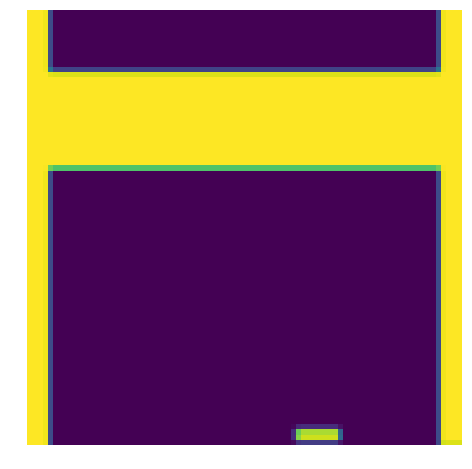

In [17]:
plot_state(observation.reshape((84,84)))

# Saving Model

In [18]:
#model.save("breakout-atari-rl.h5")

# Testing the Model

In [ ]:
mod = load_model("breakout-atari-rl.h5")

/home/sam.williams/python3.6/lib64/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


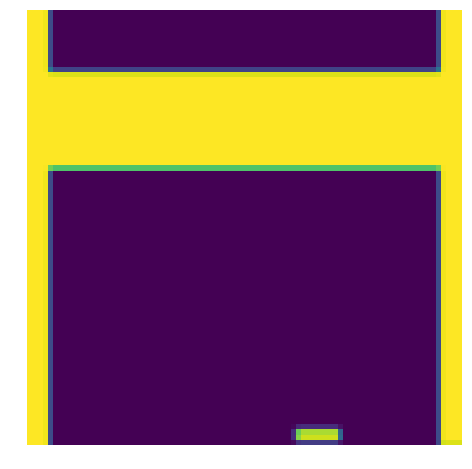

Welcome to AI Breakout!
Starting Game 1 of 10...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 2 of 10...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 3 of 10...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 4 of 10...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 5 of 10...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 6 of 10...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 7 of 10...
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 8 of 10...
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 9 of 10...
Total game score was: 1.0



In [27]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)

plot_state(observation.reshape((84,84)))

episodes = 10
gamma = 0.9
done = False
epsilon = 0.2

history = {}


for i in range(1, episodes):
    print("Welcome to AI Breakout!")
    print("Starting Game {} of {}...".format(i, episodes))
    
    sum = 0
    game = True
    obs = []
    while game:
        
        if (len(obs) == 0):
            action = 1
        elif (len(obs) > 1) and (np.array_equal(obs[-1],obs[-2])):
            action = 1
        else:
            rand = np.random.uniform(0,1)
            if  rand < epsilon:
                action = env.action_space.sample()
            else:
                observation = np.expand_dims(observation,0)
                action = np.argmax(mod.predict(observation))
            
        #print(action)
        observation, reward, done, info = env.step(action)
        observation = process_obs(observation)
        obs.append(observation)

        sum += reward
        #time.sleep(0.01)
        #env.render()

        if done:
            print("Total game score was: {}\n".format(sum))
            observation = env.reset()
            observation = process_obs(observation)
            game = False
env.close()        